In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Problem 3
(12 points)

We ask a poplutaion of $\mathcal{P}$ persons a yes/no question every week for three year and record the number of yes answers. Every persons answer is assumed to be independent of each other. We model the probability of any single person answering yes in week $t$ as $\alpha_t$, and assume the following dynamics for this process,
$$
    \alpha_{t+1} = \left(1 + \exp\left[ - a \cdot \log \left( \frac{\alpha_t}{1 - \alpha_t} \right) + \sigma \cdot \eta_{t+1} \right] \right)^{-1}, \quad \eta_{t+1} \sim \mathcal{N}(0,1)
$$
we let $\alpha_1 \sim \mathcal{U}(0,1)$ (_uniform distribution_).

**a)** We are interested in estimating the probabilities $\alpha_t$ given the sum of yes answers $y_{1:t}$, since this is a non-linear non-Gaussian model we will use a *bootstrap particle filter* to solve this problem. To implement such an algorithm we need to perform three operations, propagation, weighting, and resampling. In this first problem you should do the following:
1. Find the conditional distribution of $y_t \mid \alpha_t$.
2. Implement a function that takes $N$ particles $\alpha_t^i$ and propagates them to $\alpha_{t+1}^{i}$.
3. Implement a function that takes $N$ particles $\alpha_t^i$ and an observation $y_t$ and calculates the log-weights $\log \omega_t^i$.
<div style='text-align: right'>(4p)</div>

**Solution:**
$$y_t|\alpha_t \sim B(\mathcal{P},\alpha_t)$$

In [14]:
def logwgtfun(particles, y, population):
    """Function for propagating the particles

	:param particles: (N,) array of particles.
	:param y: the current observation

	:return logweights: (N,) array of log-weights.
	"""
    population=int(population)
    y=int(y)
    logwgt=y*np.log(particles)+(population-y)*np.log(1-particles)\
            +np.log(float(np.math.factorial(population)))\
            -np.log(float(np.math.factorial(y)))-\
            np.log(float(np.math.factorial(population-y)))
    return logwgt


def propagate(particles, a, sigma):
	"""Function for propagating the particles

	:param particles: (N,) array of particles.
	:parma sigma_eps: value of the parameter sigma_eps

	:return new_particles: (N,) array of particles.
	"""
	
	return (1+np.exp(-a*np.log(particles/(1-particles))+sigma*np.random.normal(0,1,1)))**(-1)

___

**b)** using the functions from the previous part implement a **botstrap particle filter** that runs on the data available in the file `data_problem3.csv`. Use the parameter values $a = 0.9, \sigma = 0.5$, and $\mathcal{P} = 130$. 

Provide a plot of your estimate of the sequences $\mathbb{E}[\alpha_t \mid y_{1:t}]$ and $\mathbb{P}(\alpha_t > 0.5 \mid y_{1:t})$, for $t = 1, 2, \ldots, 156$. You should use at least $N = 200$ particles in your estimates.

_hint: note that $\mathbb{P}(\alpha_t > 0.5 \mid y_{1:t}) = \mathbb{E}[ I\{\alpha_t > 0.5\} \mid y_{1:t}]$, where $I\{ \cdot \}$ is an indicator function that is $1$ when the condition is satisfied and $0$ otherwise._
(_if you failed to solve part a you can use `propagate_wrong` and `logwgtfun_wrong` from `tssltools.py`_)
<div style="text-align: right"> (5p) </div>

In [15]:
data = pd.read_csv('data_problem3.csv',header=0)
y = data['Data'].values

**Solution:**

In [16]:
def bpf(y,numParticles,params):
    
    n=len(y)
    N=numParticles
    
    ###################################################################
    a=params[0]
    sigma=params[1]
    population=params[2]
    ###################################################################
    
    # Allocate memory
    particles=np.zeros((n,N),dtype=float)
    logW=np.zeros((n,N))
    W=np.zeros((n,N))
    alpha_filt=np.zeros((n,1))
    ###################################################################
    greater_than_pointfive=np.zeros((n,1))
    ###################################################################
    logZ=0.
    
    
    
    for t in range(n):
        if t == 0:
            ###################################################################
            particles[0,:]=np.random.uniform(0, 1, N)
            ###################################################################
        else:
            #Resample
            ind=np.random.choice(N,N,replace=True,p=W[t-1,:])

            #Propogate
            particles[t,:]=propagate(particles[t-1,:], a, sigma)
        
        #Weighting
        logW[t,:]=logwgtfun(particles[t,:], y[t], population)
        W[t,:],logZ_now=exp_norm(logW[t,:])
        logZ+=logZ_now
        
        #Estimates
        alpha_filt[t,0]=np.dot(W[t,:],particles[t,:].T)
        greater_than_pointfive[t,0]=np.sum(particles[t,:]>0.5)/N
        
    return alpha_filt,greater_than_pointfive,logZ

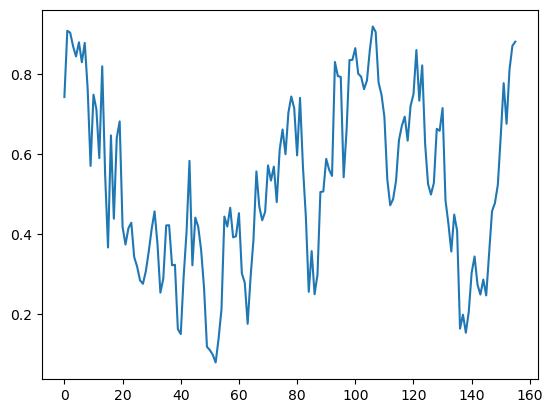

In [17]:
from tssltools import exp_norm

params=np.array([0.9,0.5,130])
alpha_filt,greater_than_pointfive,logZ=bpf(y,200,params)

# Plot
plt.plot(alpha_filt)
plt.show()

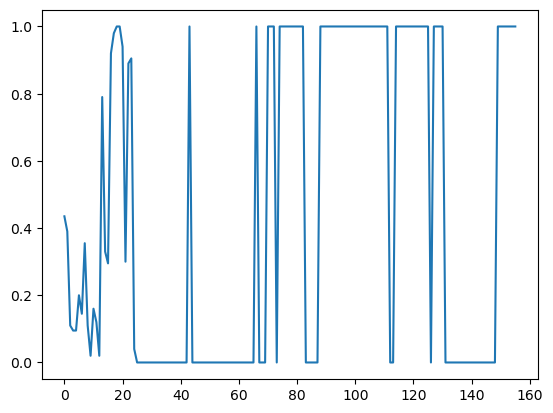

In [18]:
plt.plot(greater_than_pointfive)
plt.show()

___

**c)** The parameter $a$ is set quite arbitrary in the model above. In this problem you should perform parameter inference on this parameter. Find the value of $a$ by calculating the log-likelihood for different values of $a$, you know that the value is between $0.5$ and $1$. Find an estimate of $a$ that would be within $0.05$ of the true value.
<div style="text-align: right">(3p)</div> 

**Solution:**

The best a is 1.0

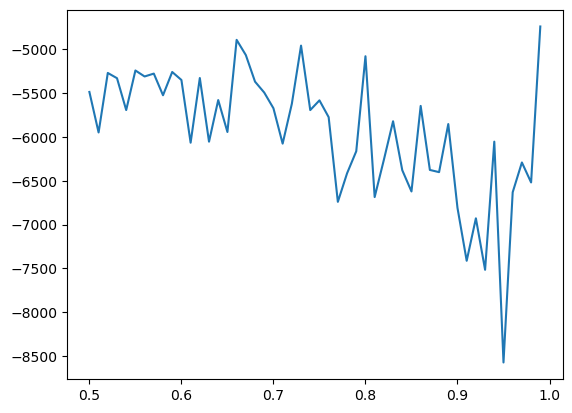

In [33]:
a_candidate=np.arange(0.5,1.0,0.01)
estimate_loglik=np.zeros((len(a_candidate),1))
for i in range(len(a_candidate)):
    logZ_cum=0
    for j in range(5):
        params=np.array([a_candidate[i],0.5,130])
        alpha_filt,greater_than_pointfive,logZ=bpf(y,200,params)
        logZ_cum+=logZ
    logZ_cum/=5
    estimate_loglik[i,0]=logZ_cum
    
plt.plot(a_candidate,estimate_loglik)
plt.show()